In [1]:
import torch
import torch.nn as nn

import torch.utils.data
from torch.utils.data.dataloader import DataLoader

from torchsummary import summary

import matplotlib.pyplot as plt
import ipywidgets

import sys
import os
from pathlib import Path

In [2]:
batch_size = 64
number_of_layers = 3
latent_space_size = 2
epochs = 20
learning_rate = 0.001
latent_space_activation_function = nn.Sigmoid()

# config = {
#     "batch_size": batch_size,
#     "number_of_layers": number_of_layers,
#     "latent_space_size": latent_space_size,
#     "epochs": epochs,
#     "learning_rate": learning_rate,
# }

# wandb.init(project="wiktor-vrije-learn.autoencoder.basic", config=config, save_code=False)

In [3]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent.joinpath("data")))

from MNIST import load_mnist_dataset

dataset, (train_data_loader, validation_data_loader, test_data_loader) = load_mnist_dataset(batch_size)

In [4]:
data_iter = iter(dataset)
data_x, data_y = next(data_iter)
print(torch.max(data_x), torch.min(data_x))

tensor(1.) tensor(0.)


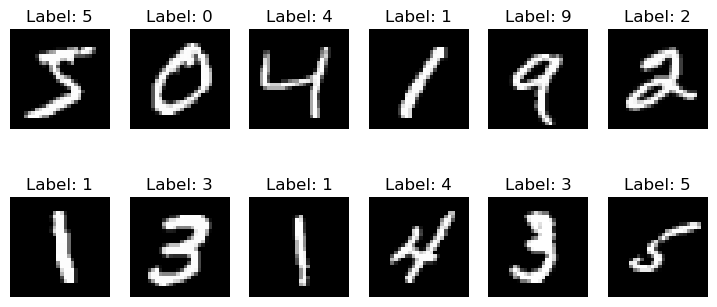

In [5]:
num_col = 6
num_row = 2
offset = 0

data_iter = iter(dataset)
for _ in range(offset):
    next(data_iter)


_, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i, ax in enumerate(axs.flatten()):
    data_x, data_y = next(data_iter)

    img = data_x.squeeze()
    ax.set_title(f"Label: {data_y}")
    ax.imshow(img, cmap="grey")
    ax.set_axis_off()

plt.show()

In [6]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent.joinpath("model")))

from MNISTAutoencoder import MNISTAutoencoder

In [7]:
model = MNISTAutoencoder(latent_space_size, number_of_layers, latent_space_activation_function)
# wandb.watch(model)

In [8]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent))

from train import train_model


print(f"Training model: {model}")


model.train()
train_model(model, learning_rate, epochs, train_data_loader)

model.eval()
0

Training model: MNISTAutoencoder:
    Latent size: 2, Layers count: 3


0

In [9]:
# For now I will do this using relative imports.
# Then I will switch to Hydra.
# TODO: switch to Hydra.
sys.path.append(str(Path(os.path.abspath('')).parent))

from evaluate import evaluate_model


validation_loss = evaluate_model(model, validation_data_loader)
test_loss = evaluate_model(model, test_data_loader)

print(f"Validation loss: {validation_loss}")
print(f"Test loss: {test_loss}")
print(f"For model {model}")
print()

Validation loss: 0.0363084115087986
Test loss: 0.036053963005542755
For model MNISTAutoencoder:
    Latent size: 2, Layers count: 3



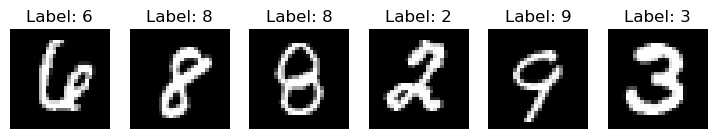

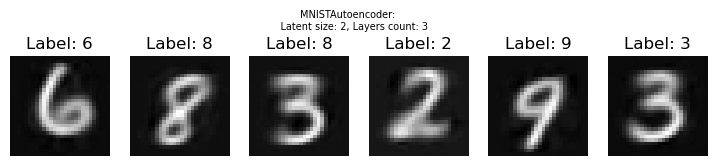

In [16]:
from random import randint

data_iter = iter(test_data_loader)
offset = randint(0, 10)
num_col = 6
num_row = 1

for _ in range(offset):
    next(data_iter)
data_x, data_y = next(data_iter)


def plot_images(data_x, title=None):
    fig, axs = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    if title:
        fig.suptitle(title, fontsize=7)

    for i, ax in enumerate(axs.flatten()):
        img = data_x[i].squeeze()
        ax.set_title(f"Label: {data_y[i]}")

        ax.imshow(img, cmap="grey")
        ax.set_axis_off()

    plt.show()


plot_images(data_x)
plot_images(model(data_x).detach().numpy(), str(model))

This is the place where you can play with the model!

In [11]:
# We used the sigmoid function, so the repr in the latent space is between 0 and 1.
eir = latent_space_ipywidgets_range = (0, 1, 0.001)


def play_with_model(model: MNISTAutoencoder):
    latent_space_params_dict = {}
    for i in range(model.latent_space_size):
        latent_space_params_dict[f"P{i+1}"] = eir

    def update(**kwargs):
        latent_space_array = list(kwargs.values())
        encoded = torch.tensor(latent_space_array).reshape(1, model.latent_space_size)
        decoded_image = model.decoder(encoded)
        plt.imshow(decoded_image.detach().numpy()[0][0], cmap="grey")

    ipywidgets.interact(update, **latent_space_params_dict)


play_with_model(model)

interactive(children=(FloatSlider(value=0.0, description='P1', max=1.0, step=0.001), FloatSlider(value=0.0, de…

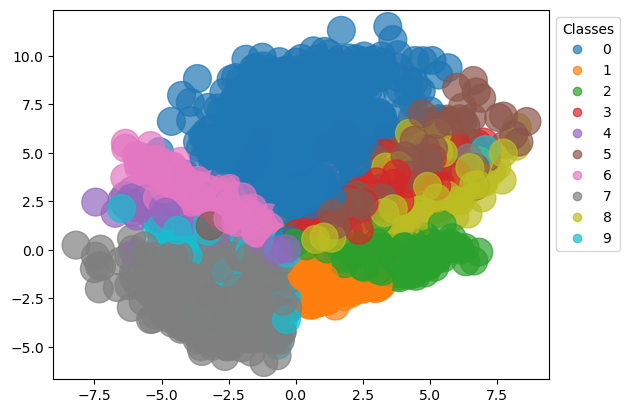

In [15]:
# The scatter plot only works when the latent_space representation is 2 dimensional.
assert model.latent_space_size == 2

import matplotlib.pyplot as plt

num_images_to_show = min(50_000, len(dataset))

encoded_latent_space_0 = []
encoded_latent_space_1 = []

labels = []
for i in range(num_images_to_show):
    x, label = dataset[i]
    x = x.reshape(1, 1, 28, 28)
    with torch.no_grad():
        latent_representation = model.encoder(x)
    latent_0, latent_1 = latent_representation[0]
    encoded_latent_space_0.append(latent_0.item())
    encoded_latent_space_1.append(latent_1.item())
    labels.append(label)


size = 20**2

scatter = plt.scatter(
    encoded_latent_space_0,
    encoded_latent_space_1,
    alpha=0.7,
    s=size,
    c=labels,
    cmap="tab10",
)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1, 1))
plt.show()